Random Search - Best Parameters: {'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'gini'}
Random Search - Best Cross-validation Score: 0.9499999999999998
Grid Search - Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Grid Search - Best Cross-validation Score: 0.9499999999999998
Test Score with Best Parameters: 1.0
Test Score with Best Parameters: 1.0
Random Search - Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Random Search - Best Cross-validation Score: 0.9500000000000001
Grid Search - Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Grid Search - Best Cross-validation Score: 0.9499999999999998
Test Score with Best Parameters from Random Search: 1.0


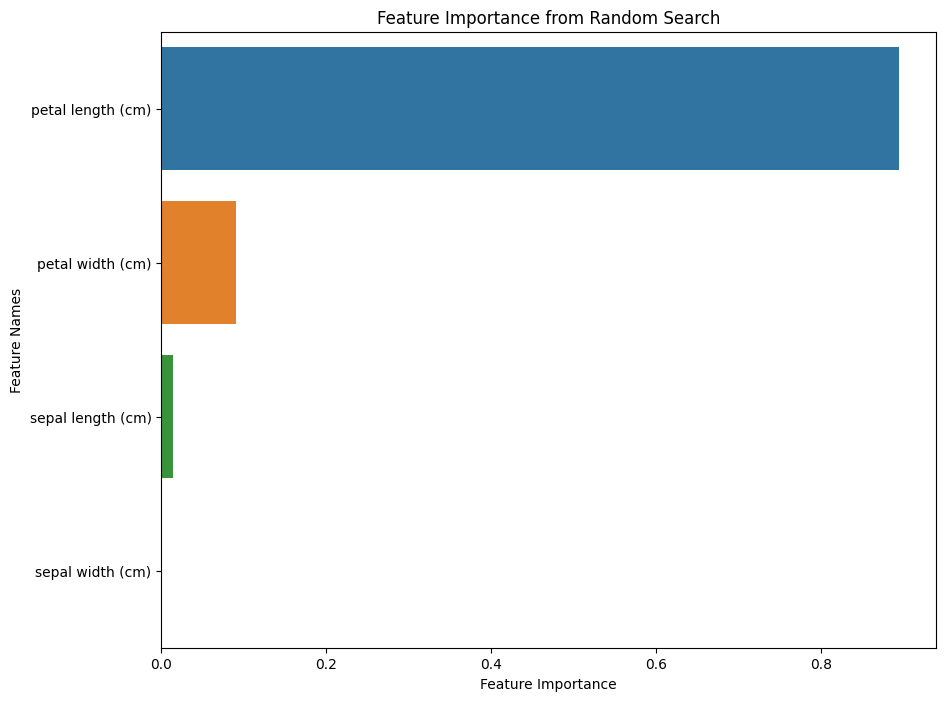

Test Score with Best Parameters from Grid Search: 1.0


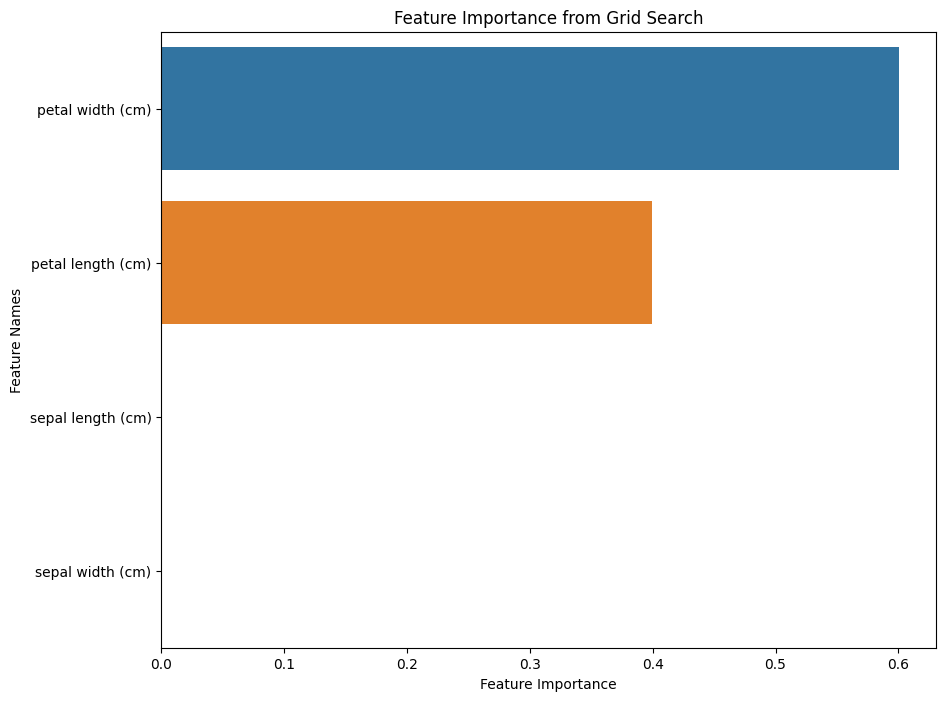

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns


def grid_search(param_grid):
    model = DecisionTreeClassifier()
    search = GridSearchCV(model, param_grid, cv=3)
    search.fit(X_train, y_train)
    return search.best_params_, search.best_score_

data = load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def random_search(num_iterations, param_grid):
    best_score = -np.inf
    best_params = {}

    for _ in range(num_iterations):
        # Sample hyperparameters randomly
        params = {param: np.random.choice(values) for param, values in param_grid.items()}

        # Create and train the model
        model = DecisionTreeClassifier(**params)
        score = np.mean(cross_val_score(model, X_train, y_train, cv=3))

        # Update best score and params if current configuration is better
        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Random Search
best_params_random, best_score_random = random_search(100, param_grid)
print("Random Search - Best Parameters:", best_params_random)
print("Random Search - Best Cross-validation Score:", best_score_random)

# Grid Search
best_params_grid, best_score_grid = grid_search(param_grid)
print("Grid Search - Best Parameters:", best_params_grid)
print("Grid Search - Best Cross-validation Score:", best_score_grid)

# model with best parameters
model_random = DecisionTreeClassifier(**best_params_random)
model_random.fit(X_train, y_train)
test_score_random = model_random.score(X_test, y_test)
print("Test Score with Best Parameters:", test_score_random)

model_grid = DecisionTreeClassifier(**best_params_grid)
model_grid.fit(X_train, y_train)
test_score_grid = model_grid.score(X_test, y_test)
print("Test Score with Best Parameters:", test_score_grid)

# Function to plot feature importance
def plot_feature_importance(importance, names, title):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # Plot feature importance
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

# Random Search
best_params_random, best_score_random = random_search(100, param_grid)
print("Random Search - Best Parameters:", best_params_random)
print("Random Search - Best Cross-validation Score:", best_score_random)

# Grid Search
best_params_grid, best_score_grid = grid_search(param_grid)
print("Grid Search - Best Parameters:", best_params_grid)
print("Grid Search - Best Cross-validation Score:", best_score_grid)

# Model with best parameters from Random Search
model_random = DecisionTreeClassifier(**best_params_random)
model_random.fit(X_train, y_train)
test_score_random = model_random.score(X_test, y_test)
print("Test Score with Best Parameters from Random Search:", test_score_random)

# Feature importance from Random Search
plot_feature_importance(model_random.feature_importances_, data.feature_names, 'Feature Importance from Random Search')

# Model with best parameters from Grid Search
model_grid = DecisionTreeClassifier(**best_params_grid)
model_grid.fit(X_train, y_train)
test_score_grid = model_grid.score(X_test, y_test)
print("Test Score with Best Parameters from Grid Search:", test_score_grid)

# Feature importance from Grid Search
plot_feature_importance(model_grid.feature_importances_, data.feature_names, 'Feature Importance from Grid Search')


In [8]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function we want to optimize
def objective(criterion, max_depth, min_samples_split, min_samples_leaf):
    # Convert some parameters to integer values
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    model = DecisionTreeClassifier(
        criterion = "gini" if criterion < 0.5 else "entropy",
        max_depth = None if max_depth == 0 else max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf
    )
    
    return np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy"))

# Use Bayesian Optimization to optimize the hyperparameters
optimizer = BayesianOptimization(
    f=objective,
    pbounds={
        "criterion": (0, 1),
        "max_depth": (0, 50),  # 0 for None
        "min_samples_split": (2, 10),
        "min_samples_leaf": (1, 4)
    },
    random_state=42,
    verbose=2
)

optimizer.maximize(n_iter=25, init_points=5)

print("Bayesian Optimization - Best Parameters:", optimizer.max['params'])

# Extracting best parameters
params_bayesian = optimizer.max['params']
params_bayesian['criterion'] = "gini" if params_bayesian['criterion'] < 0.5 else "entropy"
params_bayesian['max_depth'] = None if params_bayesian['max_depth'] == 0 else int(params_bayesian['max_depth'])
params_bayesian['min_samples_split'] = int(params_bayesian['min_samples_split'])
params_bayesian['min_samples_leaf'] = int(params_bayesian['min_samples_leaf'])

# Train the model
model_bayesian = DecisionTreeClassifier(**params_bayesian)
model_bayesian.fit(X_train, y_train)


|   iter    |  target   | criterion | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.95      | 0.3745    | 47.54     | 3.196     | 6.789     |
| 2         | 0.95      | 0.156     | 7.8       | 1.174     | 8.929     |
| 3         | 0.9333    | 0.6011    | 35.4      | 1.062     | 9.759     |
| 4         | 0.9417    | 0.8324    | 10.62     | 1.545     | 3.467     |
| 5         | 0.9417    | 0.3042    | 26.24     | 2.296     | 4.33      |
| 6         | 0.95      | 0.3934    | 47.54     | 3.284     | 6.582     |
| 7         | 0.95      | 0.0       | 0.6167    | 1.0       | 10.0      |
| 8         | 0.95      | 0.0       | 0.0       | 4.0       | 2.0       |
| 9         | 0.9333    | 0.0       | 50.0      | 1.0       | 2.0       |
| 10        | 0.95      | 0.0       | 3.181     | 3.524     | 6.595     |
| 11        | 0.925     | 0.7153    | 0.2479    | 1.035     | 4.373     |
| 12        | 0.95      | 0.02117   | 

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2,
                       min_samples_split=9)

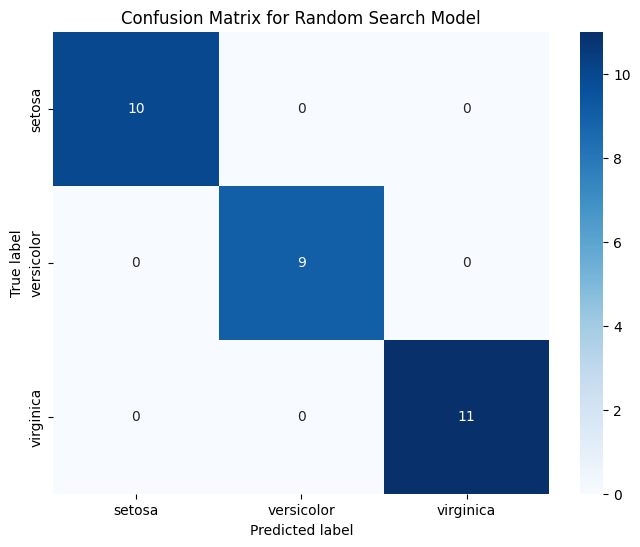

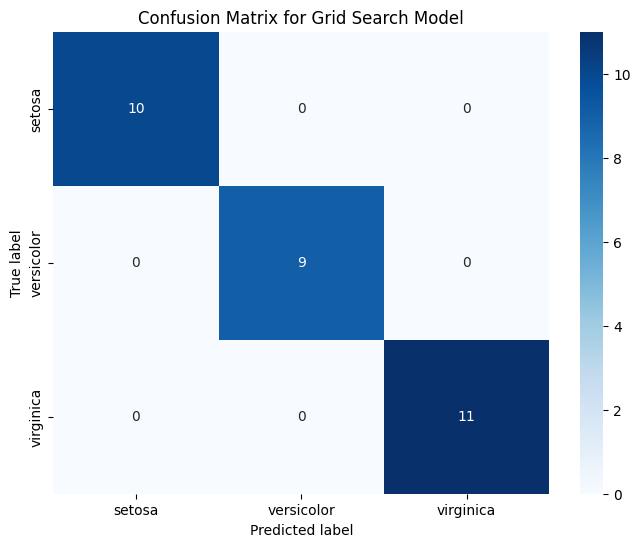

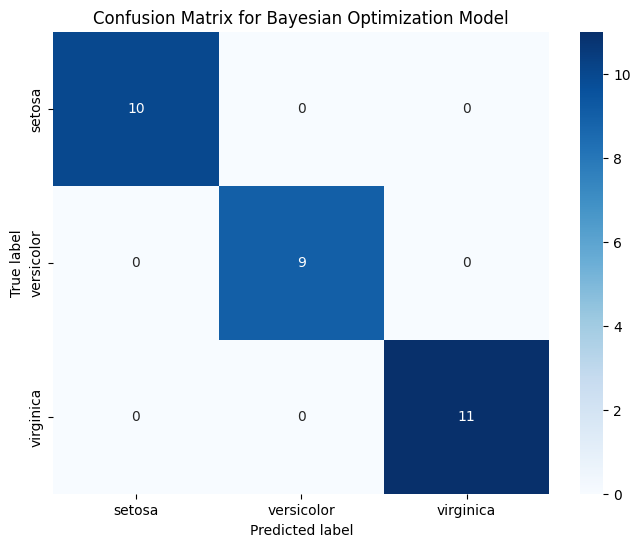

Classification Report for Bayesian Optimization Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Classification Report for Random Search Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Classification Report for Grid Search Model:
              precision    recall  f1-score   support

      setosa       1.00      1.00  

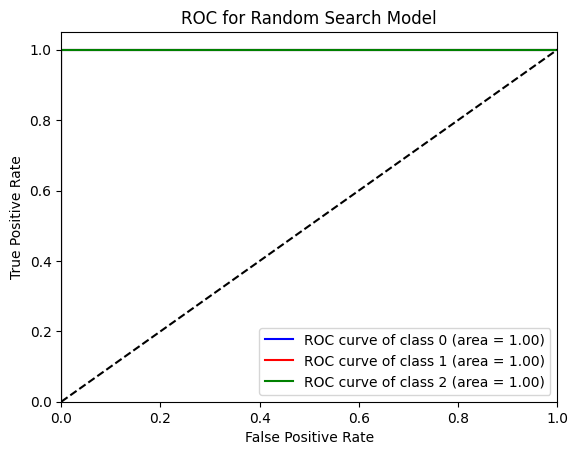

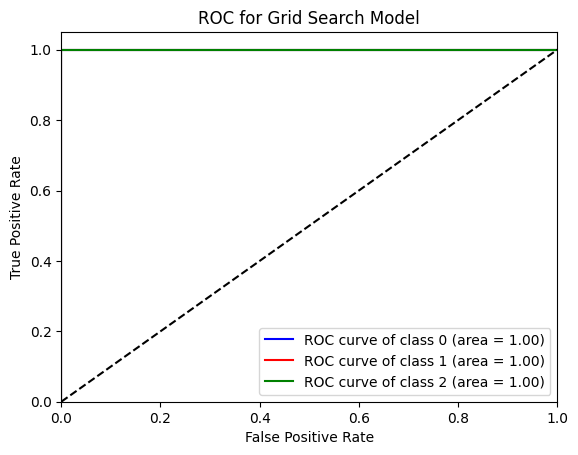

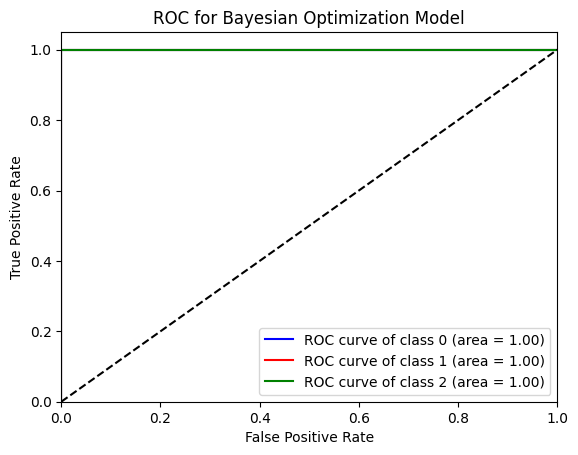

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import classification_report

y_pred_random = model_random.predict(X_test)
y_pred_grid = model_grid.predict(X_test)

def plot_confusion_matrix_heatmap(y_true, y_pred, classes, title):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot as heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# For Random Search Model
plot_confusion_matrix_heatmap(y_test, y_pred_random, data.target_names, 'Confusion Matrix for Random Search Model')

# For Grid Search Model
plot_confusion_matrix_heatmap(y_test, y_pred_grid, data.target_names, 'Confusion Matrix for Grid Search Model')

# Predictions
y_pred_bayesian = model_bayesian.predict(X_test)

# Confusion Matrix
plot_confusion_matrix_heatmap(y_test, y_pred_bayesian, data.target_names, 'Confusion Matrix for Bayesian Optimization Model')

# Classification Report
print("Classification Report for Bayesian Optimization Model:")
print(classification_report(y_test, y_pred_bayesian, target_names=data.target_names))

print("Classification Report for Random Search Model:")
print(classification_report(y_test, y_pred_random, target_names=data.target_names))

print("\nClassification Report for Grid Search Model:")
print(classification_report(y_test, y_pred_grid, target_names=data.target_names))

############################################################################################################

# Binarize the output labels for multi-class ROC
y_bin_test = label_binarize(y_test, classes=[0, 1, 2])
y_bin_pred_random = label_binarize(y_pred_random, classes=[0, 1, 2])
y_bin_pred_grid = label_binarize(y_pred_grid, classes=[0, 1, 2])
y_bin_pred_bayesian = label_binarize(y_pred_bayesian, classes=[0, 1, 2])

n_classes = y_bin_test.shape[1]

def plot_roc_curve(y_test, y_pred, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# ROC Curve
plot_roc_curve(y_bin_test, y_bin_pred_random, 'ROC for Random Search Model')
plot_roc_curve(y_bin_test, y_bin_pred_grid, 'ROC for Grid Search Model')
plot_roc_curve(y_bin_test, y_bin_pred_bayesian, 'ROC for Bayesian Optimization Model')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


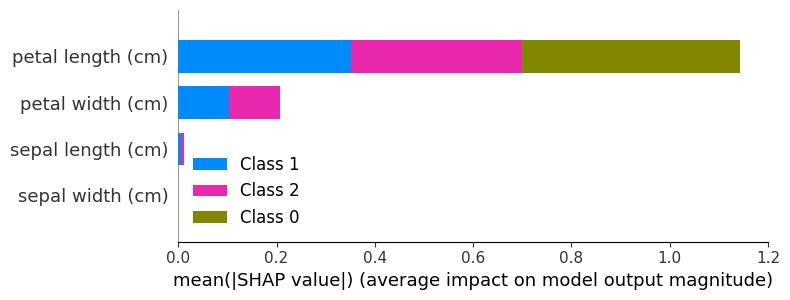

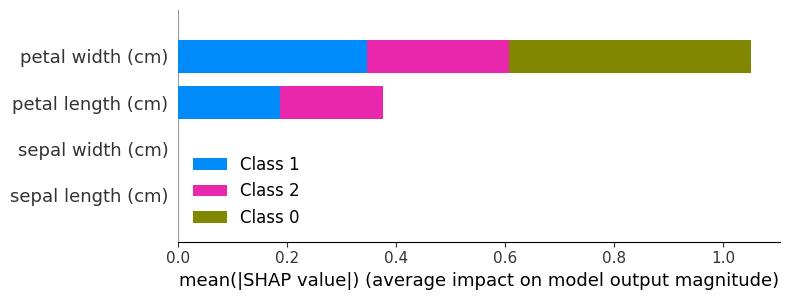

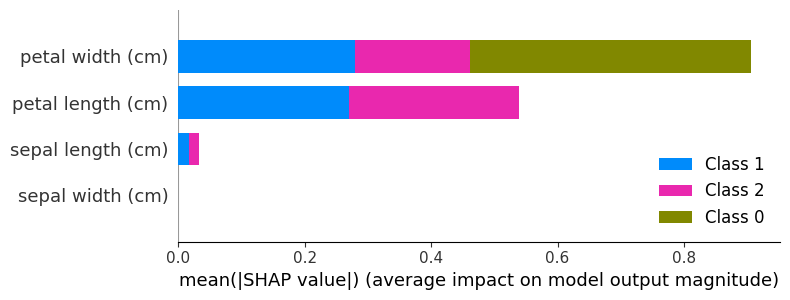

In [7]:
import shap

# Initialize JavaScript for SHAP plots
shap.initjs()

# Compute SHAP values for Random Search model
explainer_random = shap.TreeExplainer(model_random)
shap_values_random = explainer_random.shap_values(X_test)

# Visualize SHAP values for a single instance (let's say the first one)
shap.force_plot(explainer_random.expected_value[0], shap_values_random[0][0], X_test[0], feature_names=data.feature_names)

# Summary plot for Random Search model
shap.summary_plot(shap_values_random, X_test, feature_names=data.feature_names)

# Compute SHAP values for Grid Search model
explainer_grid = shap.TreeExplainer(model_grid)
shap_values_grid = explainer_grid.shap_values(X_test)

# Visualize SHAP values for a single instance (let's say the first one)
shap.force_plot(explainer_grid.expected_value[0], shap_values_grid[0][0], X_test[0], feature_names=data.feature_names)

# Summary plot for Grid Search model
shap.summary_plot(shap_values_grid, X_test, feature_names=data.feature_names)

# Compute SHAP values for Bayesian Optimization model
explainer_bayesian = shap.TreeExplainer(model_bayesian)
shap_values_bayesian = explainer_bayesian.shap_values(X_test)

# Visualize SHAP values for a single instance (let's say the first one)
shap.force_plot(explainer_bayesian.expected_value[0], shap_values_bayesian[0][0], X_test[0], feature_names=data.feature_names)

# Summary plot for Bayesian Optimization model
shap.summary_plot(shap_values_bayesian, X_test, feature_names=data.feature_names)